In [1]:
import bs4
import requests
import string
import dask.bag as db
from dask.distributed import Client
import pymorphy2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def pymorphy2_311_hotfix():
    from inspect import getfullargspec
    from pymorphy2.units.base import BaseAnalyzerUnit

    def _get_param_names_311(klass):
        if klass.__init__ is object.__init__:
            return []
        args = getfullargspec(klass.__init__).args
        return sorted(args[1:])

    setattr(BaseAnalyzerUnit, '_get_param_names', _get_param_names_311)

In [3]:
url = "http://www.lib.ru/MEMUARY/CHECHNYA/byloe.txt"
response = requests.get(url)
soup = bs4.BeautifulSoup(response.text, 'lxml')
text = soup.body.get_text(' ', strip=True)

In [4]:
client = Client(n_workers = 4, threads_per_worker = 4, processes = True, memory_limit = '2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63222,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:63251,Total threads: 4
Dashboard: http://127.0.0.1:63252/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:63225,


In [5]:
words_list = text.lower().translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits)).split()

In [6]:
len(words_list)

130364

In [8]:
pymorphy2_311_hotfix()
morph = pymorphy2.MorphAnalyzer()

In [9]:
lemmatized_words = [morph.parse(word)[0].normal_form for word in words_list if len(word) >= 3]

In [11]:
data = pd.DataFrame(lemmatized_words, columns=["words"])
data

,words
0,fbzip
1,epub
2,содержание
3,fine
4,html
...,...
101766,популярность
101767,lastmodified
101768,fri
101769,oct


In [12]:
words_count = data['words'].value_counts().reset_index()
words_count.columns = ['word', 'count']
words_count

,word,count
0,что,1789
1,быть,1632
2,как,976
3,это,960
4,всё,893
...,...,...
12347,fbzip,1
12348,epub,1
12349,содержание,1
12350,fine,1


In [82]:
words_count.head(10)

,word,count
0,что,1789
1,быть,1632
2,как,976
3,это,960
4,всё,893
5,мы,872
6,он,833
7,они,723
8,свой,696
9,я,643


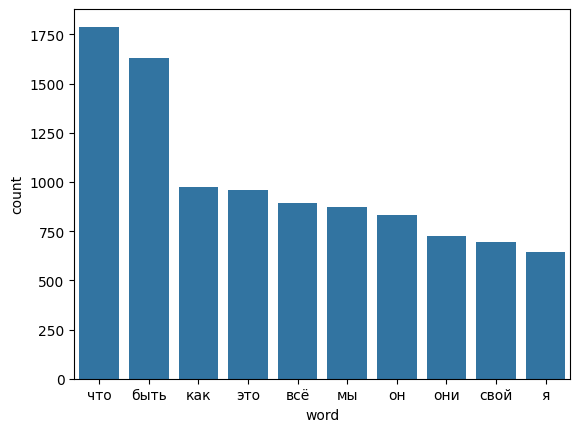

In [14]:
sns.barplot(words_count.head(10), x='word', y='count')
plt.show()

### А теперь то же самое только с даском

In [15]:
words_db = db.from_sequence(words_list)

In [29]:
def process_text(word):
    pymorphy2_311_hotfix()
    morph = pymorphy2.MorphAnalyzer()
    lemmatized_words = morph.parse(word)[0].normal_form
    return lemmatized_words #[word for word in lemmatized_words if len(word) >= 3]

In [17]:
process_text("глючит")

'глючить'

In [ ]:
words_db.compute() #Это выполняется за 9 сек. В массиме 130000 слов.

['fbzip',
 'epub',
 'содержание',
 'fine',
 'html',
 'printed',
 'version',
 'txtwordкпк',
 'libru',
 'html',
 'вячеслав',
 'миронов',
 'я',
 'был',
 'на',
 'этой',
 'войне',
 'чечня',
 'вы',
 'можете',
 'купить',
 'этот',
 'роман',
 'в',
 'виде',
 'электронной',
 'книги',
 'цена',
 'руб',
 'вырученные',
 'деньги',
 'пойдут',
 'на',
 'развитие',
 'сайта',
 'artofwarru',
 '©',
 'copyright',
 'вячеслав',
 'миронов',
 'редактор',
 'владимир',
 'григорьев',
 'vovaduxru',
 'военный',
 'редактор',
 'василий',
 'максимович',
 'шнипов',
 'корректорская',
 'правка',
 'справочная',
 'служба',
 'русского',
 'языка',
 'корректорская',
 'правка',
 'лада',
 'славникова',
 'августа',
 'размещена',
 'полная',
 'версия',
 'романа',
 'оригинал',
 'этого',
 'файла',
 'расположен',
 'на',
 'сайте',
 'artofwarru',
 'автор',
 'ждет',
 'ваших',
 'отзывов',
 'оставляйте',
 'их',
 'в',
 'авторской',
 'гостевой',
 'english',
 'version',
 'assault',
 'on',
 'grozny',
 'downtown',
 'german',
 'ich',
 'war',
 'in'

In [ ]:
words_db.count().compute() # А это выполняется 13 сек. Что уже намекает на какую-то проблему.

130364

In [30]:
keywords = words_db.map(process_text)
keywords.compute() # А в этом месте программа зависает.

KeyboardInterrupt: 

In [38]:
#bag = db.from_sequence([words])
keywords = words.map(process_text)
keywords.compute()
all_keywords = keywords.flatten()
keyword_counts = all_keywords.frequencies()
pd.DataFrame(keyword_counts, columns=['Word', 'Frequency']).sort_values(by="Frequency", ascending = False)

KeyboardInterrupt: 